In [1]:
# import sys
# !{sys.executable} -m pip install python-igraph simpy numpy scipy matplotlib
# !{sys.executable} -m pip install cpython
# !{sys.executable} -m pip install runstats
# !{sys.executable} -m pip install pandas

In [2]:
import igraph
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import default_rng, RandomState
import pandas as pd
from scipy import stats
from simpy import *
from simpy.events import AnyOf, AllOf, Event
from simpy.resources.store import *

In [3]:
# %matplotlib

Using matplotlib backend: MacOSX


In [509]:
# %matplotlib inline
%matplotlib inline
plt.rcParams["figure.figsize"] = [16,12]

# Configuration

In [4]:
# All durations are in seconds

# targeted mean block time
MEAN_BLOCK_TIME = 30

# number of blocks in an epoch
EPOCH = 120

# Median delay of pact new block calls delay
PACT_NEW_BLOCK_TIME = 0.05

# The mean latency for propagating a block in the network
NETWORK_LATENCY = 0.5

# overall block latencies (validation + network + validation, including pact validation)
NUMBER_OF_MINING_NODES = 2
LOCAL_BLOCK_LATENCY = 2 * PACT_NEW_BLOCK_TIME
REMOTE_BLOCK_LATENCY = 2 * PACT_NEW_BLOCK_TIME + NETWORK_LATENCY

# Seed for the PRNG
RNG_SEED = 17

# Preliminaries

## Random Number Generator

In [5]:
prng = default_rng(RNG_SEED)
prng_ = RandomState(RNG_SEED) # scipy uses the legacy generator

## Graphs

Chainweb graphs are undirected and regular graphs that are choosen to have low degree and low diameter. 

Each vertex of a Chainweb graph represents a chain and edges designate the dependencies between blocks on different chains. A block on chain $c$ at height $h$ has to reference each block of height $h-1$ on all chains that are adjacent to $c$. In addition a block at height $h$ also depends on the block at height $h-1$ on the same chain. We also say that a chain $c$ depends on a chan $d$ if $c$ is adjacent to $d$.

Since Chainweb graphs are undirected, dependencies between chains are symmetric. Thus, In the following we encode dependencies using directed, symmetric directed graphs. We also make them reflexiv, by making each vertex adjacent to itself, because each each block depends on its parent on the same chain.

The $\text{Peterson}$ graph is of minimal order (number of vertices) for degree 3 and diameter 2. 

In [6]:
def peterson():
    graph = igraph.Graph(directed=True)
    graph.add_vertices(10)
    graph.add_edges(
        [ (0, 0), (0, 2), (0, 3), (0, 5)
        , (1, 1), (1, 3), (1, 4), (1, 6)
        , (2, 2), (2, 0), (2, 4), (2, 7)
        , (3, 3), (3, 0), (3, 1), (3, 8)
        , (4, 4), (4, 1), (4, 2), (4, 9)
        , (5, 5), (5, 0), (5, 6), (5, 9)
        , (6, 6), (6, 1), (6, 5), (6, 7)
        , (7, 7), (7, 2), (7, 6), (7, 8)
        , (8, 8), (8, 3), (8, 7), (8, 9)
        , (9, 9), (9, 4), (9, 5), (9, 8)
        ]
    )
    return(graph)

Peterson = peterson()

The $\text{Twenty}$ chain graph is of minimal order for degree 3 and diameter 3.

In [7]:

def twenty():
    graph = igraph.Graph(directed=True)
    graph.add_vertices(20)
    graph.add_edges(
        [ (0, 0), (0, 10), (0,15), (0,5)
        , (1, 1), (1, 11), (1,16), (1,6)
        , (2, 2), (2, 12), (2,17), (2,7)
        , (3, 3), (3, 13), (3,18), (3,8)
        , (4, 4), (4, 14), (4,19), (4,9)
        , (5, 5), (5, 0), (5,7), (5,8)
        , (6, 6), (6, 1), (6,8), (6,9)
        , (7, 7), (7, 2), (7,5), (7,9)
        , (8, 8), (8, 3), (8,5), (8,6)
        , (9, 9), (9, 4), (9,6), (9,7)
        , (10, 10), (10, 0), (10,11), (10,19)
        , (11, 11), (11, 1), (11,10), (11,12)
        , (12, 12), (12, 11), (12,13), (12,2)
        , (13, 13), (13, 12), (13,14), (13,3)
        , (14, 14), (14, 13), (14,15), (14,4)
        , (15, 15), (15, 0), (15,14), (15,16)
        , (16, 16), (16, 1), (16,15), (16,17)
        , (17, 17), (17, 16), (17,18), (17,2)
        , (18, 18), (18, 17), (18,19), (18,3)
        , (19, 19), (19, 10), (19,18), (19,4)
        ]
    )
    return (graph)

Twenty = twenty()

## Histogram

Quick and Dirty Linear Histograms.

In [8]:
# TODO: there are probably some good libraries with support for this
#
class Histogram:

    def __init__(self, binSize):
        self.bins = {}
        self.binSize = binSize

    def sample(self, x):
        i = math.floor(x / self.binSize)
        if i in self.bins:
            self.bins[i] += 1
        else:
            self.bins[i] = 1

    def append(self, h):
        if h.binSize == self.binSize:
            for i in h.bins:
                if i in self.bins:
                    self.bins[i] += h.bins[i]
                else:
                    self.bins[i] = h.bins[i]
        else:
            throw("merging histograms with different bin sizes isn't yet implemented")

    def result(self):
        imin = min(self.bins.keys())
        imax = max(self.bins.keys())
        a = [0] * (imax - imin + 1)
        b = [self.binSize * k for k in range(imin, imax + 1)]
        for i in range(imin, imax + 1):
            if i in self.bins:
                a[i - imin] = self.bins[i]
        return a, b

# TODO: implement more general WithStatistics class
class HistogramSample:
    def __init__(self, histogram, clock):
        self.histogram = histogram
        self.clock = clock
    def __enter__(self):
        self.start = self.clock.now
        return self.start
    def __exit__(self, type, value, traceback):
        self.histogram.sample(self.clock.now - self.start)
        return None # rethrow

# Simulation Model

The goal of the simulation is to investigate the interaction of dependencies between chains and difficulty adjustement in the computation of a single chain. 

Block production (*mining*) on each chain is exponentially distributed.
The mean mining time is called the $\text{target}$. Mining on a chain can only proceed if all dependencies are available. I.e. a block on chain $c$ at height $h$ can be mined only after all blocks at height $h-1$ have been mined on $c$ and all chains adjacent to $c$. We say that a chain is *blocked* when it is done mining a block and while it is waiting for dependencies for the next block to become available. The overall *block time* is the time that it takes a chain to do a full cycle from starting to mine a block to starting to mine the next block, i.e. the time that mining takes, plus the time it is blocked, plus any potential additional latencies. 

POW blockchain algorithms are desigined such that the overall block time resembles an exponential distriution with a particular mean. The goal of *Difficulty Adjustment* is to adjust the target such that the observed mean matches the targeted mean. Single chain POW block chains can't be blocked and block times are exponentially distributed when the mining time dominates the other latencies. This can be achieved by choosing the a block time that is sufficiently large compared to network propgation and validation times. (For the purpose of this research, we are ignoring races that result in orphans.) In Chainweb chains can additionally be blocked and the distribution of the block time results from the the combination of the mining distribution, the distribution of times that chains are blocked, and the distribution of other latencies (network propagation and block validation).

The model is designed to investigate how the choice of the difficulty adjustment algorithm affect the overall resulting block time distribution in Chainweb.

We don't model consensus. Therefore the model doesn't include races between distributed nodes and orphan blocks. Because there are no conflicts only a single block for each chain and height is produced. Thus, blocks are uniquly identified by their chain and height. Also, each block is used exactly once by each adjacent chain. In other words a single linear chainweb is produced without any forks. 

Each vertex in the graph is labeled with a `Chain`, which is implemented as a `Process` that mines blocks on that chain. 

Dependencies between chain processes are implemented by passing messages with new blocks to adjacent chains. A chain can only produce a new block if all of its dependencies have been received. Each (directed) edge is assigned a communication channel. The source chain of an edge publishes new blocks to the channel. The target of the edge can receive a block ar specific height by awaiting that block on the channel.

## Durations

We use the generic term $\text{latency}$ to summarize the duration of the validation of a block after it is discovered and before it is published, the network latency, and the validation after it is received. In case a block is discovered on the same node the network latency and one validation step are omitted. This is modeled by using a Bernoulli distribution to estimate the chance that a block is mined locally and a reduced latency is used.

Pact new block validation is modeled separately because, depending on the mining framework that is used, it is applied after a chain becomes unblocked.

In [9]:
def gamma5(mean):
    return prng.gamma(shape=5, scale=mean/5)

# latency: validation + network + validation
def latencyDelay():
    is_local = prng.binomial(n=1, p = 1 / NUMBER_OF_MINING_NODES)
    if is_local:
        return gamma5(LOCAL_BLOCK_LATENCY)
    else:
        return gamma5(REMOTE_BLOCK_LATENCY)

# Pact new block
def pactDelay():
    return gamma5(PACT_NEW_BLOCK_TIME)

# Mining is exponentialy distributed with the target being the mean
def miningDelay(target):
    return prng.exponential(target)

## Blocks

In [10]:
class Block:
    def __init__(self, chainId, height, time, epochTime, target):
        self.chainId = chainId
        self.height = height
        self.time = time

        # For Da
        self.epochTime = epochTime
        self.target = target

        def __lt__(self, other):
            self.height < other.height

## Difficulty Adjustment Algorithms

In [500]:
def avg(a): 
    return sum(a) / len(a)

# DA that does local adjustments based on a globally
# synchronized epoch.
#
# This is what is currently implemented on mainnet.
#
class ChainDA:
    def __init__(self, env):
        self.env = env
        
    def run(self, parent, parents):
        return self.runChain(parent)
    
    def runChain(self, parent):
        if parent == None:
            return self.env.now, MEAN_BLOCK_TIME
        if (parent.height + 1) % EPOCH == 0:
            epochTime = parent.time
            target = parent.target * (MEAN_BLOCK_TIME * EPOCH) / (parent.time - parent.epochTime)
        else:
            epochTime = parent.epochTime
            target = parent.target
        return epochTime, target

# DA that is based on globally synchronized epoch. It performs
# chainDa and takes the average for the chain along with all it's
# adjacent chains.
#
class AvgDA(ChainDA):
    
    def __init__(self, env): super().__init__(env)

    def run(self, parent, parents):
        if parent == None:
            return self.env.now, MEAN_BLOCK_TIME
        if (parent.height + 1) % EPOCH == 0:
            ps = list(parents)
            ps.append(parent)
            epochTimes, targets = zip(*[self.runChain(p) for p in ps])
            epochTime = avg(epochTimes)
            target = avg(targets)
        else:
            epochTime = parent.epochTime
            target = parent.target
        return epochTime, target

  
# A DA algorithm that adjusts difficutly on a per chain basis
# based on the solve time for that chain.
#
class LocalDA(ChainDA):
    def __init__(self, env): super().__init__(env)

    def run(self, parent, parents):
        if parent == None:
            return self.env.now, MEAN_BLOCK_TIME
        if (parent.height + 1) % EPOCH == 0:
            epochTime = parent.time
            target = parent.target * (MEAN_BLOCK_TIME * EPOCH) / (parent.time - parent.epochTime)
        else:
            ps = list(parents)
            ps.append(parent)
            penalty = avg([p.time for p in ps]) - parent.time # approximation of wait time
            epochTime = parent.epochTime + penalty
            target = parent.target
        return epochTime, target

## Mining

The target multiplier can be used to simulate a situation where different chains receive different
amounts of hash power or use different hash algorithms.

In [624]:
class Mine(Process):
    def __init__(self, env, da, chainId, parent, parents, useTargetMultiplier = True):
        
        self.env = env
        self.parent = parent
        self.parents = parents
        self.chainId = chainId
        self.da = da
        self.targetMultiplier = self.chainId if useTargetMultiplier else 0

        super().__init__(env, self.run())


    def run(self):
        # adjust difficulty
        epochTime, target = self.da.run(self.parent, self.parents)
        
        height = 0 if self.parent == None else self.parent.height + 1

        # mine
        solveTime = miningDelay(target * (1 + self.targetMultiplier))
        newTime = self.env.now # current behavior
        yield self.env.timeout(solveTime)
        newTime += solveTime * 0.5 # proposed behavior

        # create new block
        block = Block(
                chainId = self.chainId,
                height = height,
                time = newTime,
                epochTime = epochTime,
                target = target
            )
        return block

## Chain

In [625]:
class AwaitParents(Process):
    def __init__(self, env, graph, block : Block):
    
        def run():
            # No parents for the genesis block
            if block == None: return []
    
            chainId = block.chainId
            edges = graph.vs[chainId].in_edges()
            f = lambda b: b.height == block.height
            results = yield AllOf(env, [ FilterStoreGet(e["link"], f) for e in edges ])
            parents = list(results.values())
            return parents
    
        super().__init__(env, run())

In [626]:
# asynchronously publish block to each adjacent chain
#
# TODO should this an process or is it fine for it to be instantaneous?
#
class Publish:
    def __init__(self, env, graph, block):
        self.env = env
        self.graph = graph
        self.block = block
        self.chain = block.chainId
        self.run()

    def run(self):
        for e in self.graph.vs[self.chain].out_edges():
            self.env.process(self.publishToChain(e))
        
    def publishToChain(self,e):
        yield self.env.timeout(latencyDelay())
        yield StorePut(e["link"], self.block)

In [627]:
class Chain:
    def __init__(self, env, chainId : int, graph, da, binSize : int = 1):

        # Context
        self.env = env
        self.graph = graph
        self.chain = chainId
        self.da = da

        # State
        self.currentBlock = None

        # Monitors and Statistics
        self.isBlocked = False        
        self.cycleTimes = []
        self.blockedTimes = []
        self.newBlockTimes = []
        self.mineTimes = []
        self.targets = []

        # start chain process
        self.action = env.process(self.run())
        
    def run(self):
        t=None
        while True:
            t0 = self.env.now

            # await parents for new block
            t1 = self.env.now
            self.isBlocked = True
            parents = yield AwaitParents(self.env, self.graph, self.currentBlock)
            self.isBlocked = False
            self.blockedTimes.append(self.env.now - t1)

            # pact new block (TODO: do we call this here? There should
            # no reason to wait for *all* adjacents for calling new block)
            d = pactDelay()
            yield self.env.timeout(d)
            self.newBlockTimes.append(d)

            # mine
            t1 = self.env.now
            block = yield Mine(self.env, self.da, self.chain, self.currentBlock, parents)
            self.mineTimes.append(self.env.now - t1)
            self.currentBlock = block
            self.targets.append(block.target)
                    
            # publish block asynchronously
            Publish(self.env, self.graph, block)
                
            self.cycleTimes.append(self.env.now - t0)

## Chainweb

In [628]:
class Chainweb:

    def __init__(self, env, graph, da, binSize : int = 1):
        self.graph = graph
        self.env = env
        self.binSize = binSize
        self.da = da

        for i in self.graph.es:
            i["link"] = FilterStore(env)

        for i in self.graph.vs:
            chain = Chain(env, i.index, self.graph, self.da, binSize)
            i["chain"] = chain
        
        self.chains = self.graph.vs["chain"]

# Statistics

In [629]:
# Monitor the value of variables at fixed intervals
#
def monitor(env, chainweb, n):
    blocked = []
    while True:
        yield env.timeout(n)
        cur = [ i.isBlocked for i in chainweb.graph.vs["chain"] ]
        blocked.append(sum(cur)/ len(cur))
        print("[%d][MONITOR] %d%% blocked" % (env.now, 100 * sum(cur) / len(cur)))

# Main

In [630]:
def main(graph, n):
    binSize = 0.1
    env = Environment()
    cw = Chainweb(env, graph, LocalDA(env), binSize)
    m = env.process(monitor(env, cw, n/10))
    env.run(until=n)
    return cw

# Run Simulation

We run the simulation in three different configurations:

1.  No chain target multipliers and `ChainDA`
2.  No chain target mulitpliers and `AvgDA`
3.  per chain target multipliers and `LocalDA`

Different target multipliers simulate a situation where different chains receive different hash power or use different hash algorithms.

Results for scenario 1. and 2. don't depend on the choice of that block time within the allowed range, i.e. strictly larger than the parent time and smaller than the real time when the block is solved. But both
scenarios can't handle target multipliers.

Scenario 3. yields robust results when target multipliers are used, but depends on the block times chosen to be close to the actual solve time. If the block times that don't depend on the solve time result in unstable DA and very long blocked times on some chains, which means that mining on those chains becomes a lotery that doesn't depend on hash power.

In the third scenario it seems that the DA is unstable under poorly chosen block times even if no multipliers are used (TODO: double check that claim). This indicates that the natural noise in the solve times is amplified by the algorithm. The quality of the choice of the block time affects the convergence speed. It's not yet clear whether it also affects the quality of DA once the chains reach their plateau.

In [631]:
cw = main(Twenty, 500000)
chains = cw.chains

[50000][MONITOR] 70% blocked
[100000][MONITOR] 70% blocked
[150000][MONITOR] 75% blocked
[200000][MONITOR] 50% blocked
[250000][MONITOR] 45% blocked
[300000][MONITOR] 60% blocked
[350000][MONITOR] 70% blocked
[400000][MONITOR] 70% blocked
[450000][MONITOR] 70% blocked


# Results

In [632]:
cs = {}
cs["cycle times"] = np.array([np.array(c.cycleTimes) for c in chains])
cs["blocked times"] = np.array([np.array(c.blockedTimes) for c in chains])
cs["targets"] = np.array([np.array(c.targets) for c in chains])
cs["new block times"] = np.array([np.array(c.newBlockTimes) for c in chains])
cs["mine times"] = np.array([np.array(c.mineTimes) for c in chains])

In [633]:
pd.options.display.float_format = '{:,.4f}'.format

In [634]:
def plotHist(chains, bins = 100, cols=1):
    fig = plt.figure()
    rows = math.floor(len(chains) / cols)
    for i,(t,c) in enumerate(chains.items()):
        p = fig.add_subplot(rows, cols, i+1)
        data = np.concatenate(c)
        p.hist(data, bins=bins)
        p.set_xlabel("time")
        p.set_ylabel(t)

## Overview

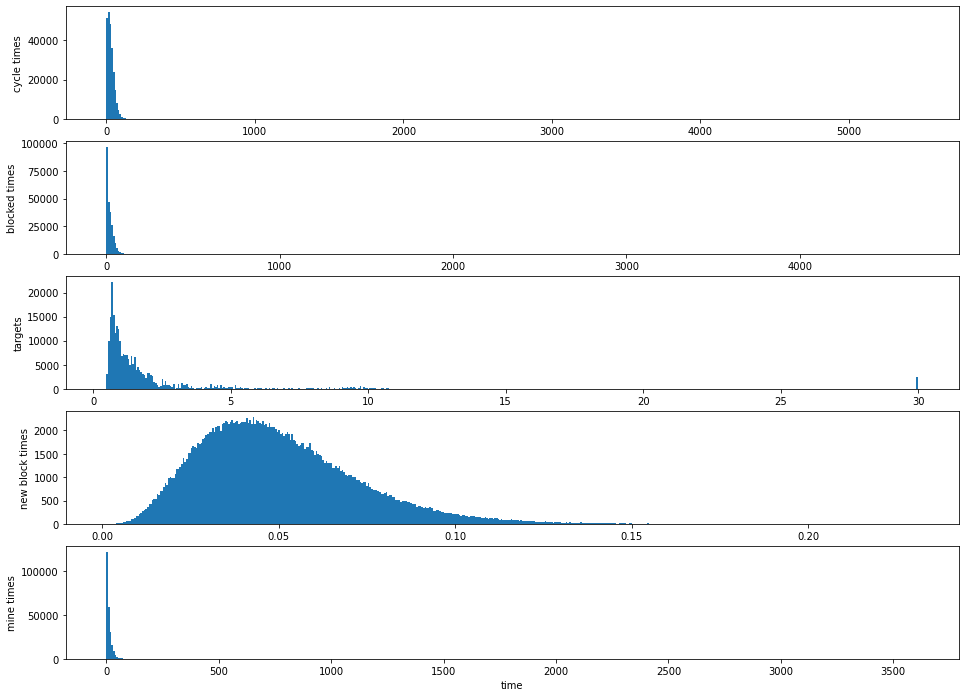

In [635]:
plotHist(cs, bins=500)

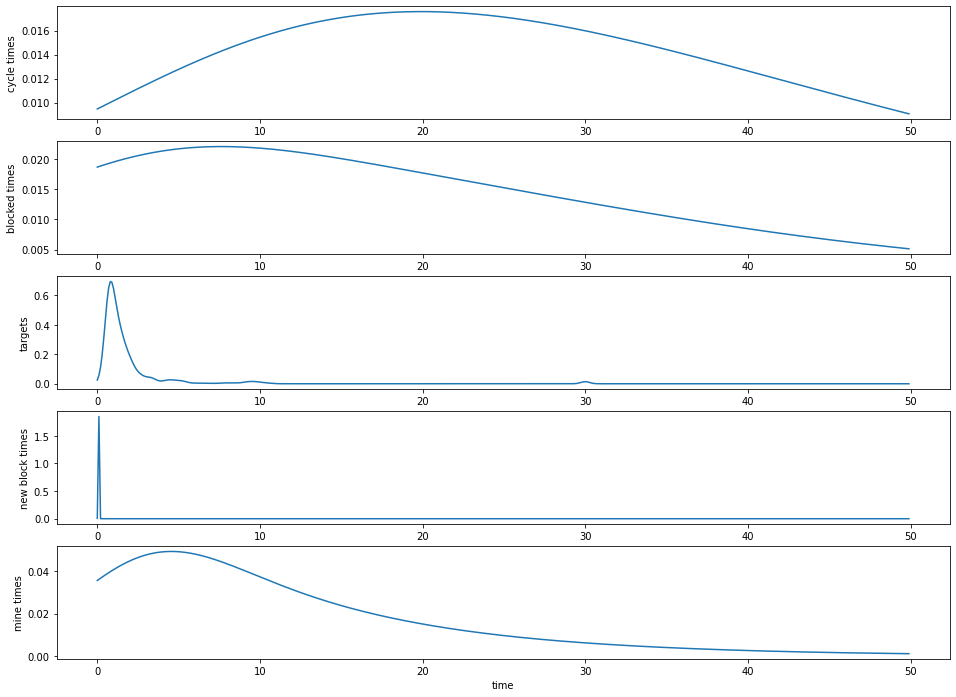

In [636]:
l = 10
cols = 1
fig = plt.figure()
rows = math.floor(len(cs) / cols)
x = np.arange(start=0, stop=50, step=0.1)
for i,(t,c) in enumerate(cs.items()):
    p = fig.add_subplot(rows, cols, i+1)
    data = np.concatenate(c)
    p.plot(x, stats.gaussian_kde(data)(x), label=t)
    p.set_xlabel("time")
    p.set_ylabel(t)
    
# plt.plot(x, (stats.expon.pdf(x, scale=l)), label="targeted solve time")
# plt.plot(x, (stats.gaussian_kde(np.concatenate(cs["b"])))(x), label="blocked time")
# plt.plot(x, (stats.expon.pdf(x, scale=l)) + (stats.gaussian_kde(np.concatenate(cs["b"])))(x), label="sum")
# plt.legend()
# plt.show()

In [637]:
dat = pd.DataFrame(data=cs)
dat2 = dat.applymap(lambda x: stats.describe(x)._asdict())
dat3 = pd.concat({ i: x.apply(lambda x: pd.Series(x)) for i, x in dat2.iterrows() }
    ).reorder_levels([1,0]
    ).sort_index(level=0)
dat3[['min', 'max']] = pd.DataFrame(dat3['minmax'].tolist(), index=dat3.index)
del dat3['minmax']
dat3.loc['targets']

,nobs,mean,variance,skewness,kurtosis,min,max
0,12384,7.2243,14.7352,1.5103,10.0316,0.6671,30.0000
1,12384,4.3068,8.0730,7.0087,61.9833,0.6606,30.0000
2,12384,2.9625,7.7918,8.7599,82.3383,0.6135,30.0000
3,12383,2.3736,7.8297,9.3047,89.1049,0.5750,30.0000
4,12384,1.9829,7.8688,9.6455,93.4456,0.6224,30.0000
5,12383,2.2059,7.6064,9.9159,96.9721,0.8847,30.0000
6,12384,1.8804,7.7650,9.9559,97.4965,0.7117,30.0000
7,12384,1.7237,7.8434,9.9723,97.7095,0.6666,30.0000
8,12383,1.6137,7.8999,9.9824,97.8367,0.7691,30.0000
9,12384,1.4886,7.9632,9.9940,97.9926,0.7178,30.0000


In [638]:
dat3.loc['cycle times']

,nobs,mean,variance,skewness,kurtosis,min,max
0,12384,40.3735,"18,812.6075",16.6216,342.5705,0.1690,"4,673.1864"
1,12384,40.3743,"18,970.8782",15.7749,293.4527,0.1101,"3,853.8942"
2,12384,40.3745,"19,080.5911",15.4053,272.3200,0.1255,"3,429.8179"
3,12383,40.3767,"17,910.6132",15.3679,278.3278,0.1229,"3,509.0511"
4,12384,40.3729,"19,669.9725",17.4120,377.4804,0.1302,"4,816.6524"
5,12383,40.3743,"17,696.7166",16.3173,353.6385,0.1302,"5,020.0422"
6,12384,40.3737,"18,219.4312",15.3853,276.1723,0.1217,"3,304.2115"
7,12384,40.3737,"19,017.7861",15.6644,285.9920,0.1884,"3,660.4313"
8,12383,40.3766,"17,420.8626",15.2951,286.2354,0.0819,"3,715.2354"
9,12384,40.3735,"18,922.5706",16.3153,320.6272,0.1282,"4,037.0558"


In [639]:
dat3.loc['blocked times']

,nobs,mean,variance,skewness,kurtosis,min,max
0,12384,33.1117,"18,277.7535",16.7685,349.0843,0.0000,"4,670.9346"
1,12384,31.6862,"17,782.7423",16.1414,305.9509,0.0000,"3,829.3961"
2,12385,31.4378,"17,303.4597",16.0599,297.9851,0.0000,"3,421.2081"
3,12384,30.7114,"15,330.6125",15.9883,299.4402,0.0000,"3,283.5885"
4,12385,30.5317,"16,951.9309",18.4327,422.0936,0.0000,"4,681.8738"
5,12384,27.0222,"14,009.6589",17.2178,386.9282,0.0000,"4,498.7228"
6,12384,27.1391,"14,726.4217",16.8173,331.3122,0.0000,"3,188.5702"
7,12384,26.2442,"13,088.6893",16.7414,320.8135,0.0000,"2,867.5882"
8,12384,26.1003,"12,604.2015",17.4745,383.5732,0.0000,"3,701.4221"
9,12385,25.3346,"11,708.8691",18.3615,423.3783,0.0000,"4,003.9976"


## Blocked Times

An important property of DA is that no chain should be blocked more often than other. 

In case that chains use different multipliers on their target during mining, we expect that initially chains with smaller multipliers are blocked for longer, because they resolve blocks faster. In those cases the use of `LocalDA` is expected to resolve the differences within a few epochs.

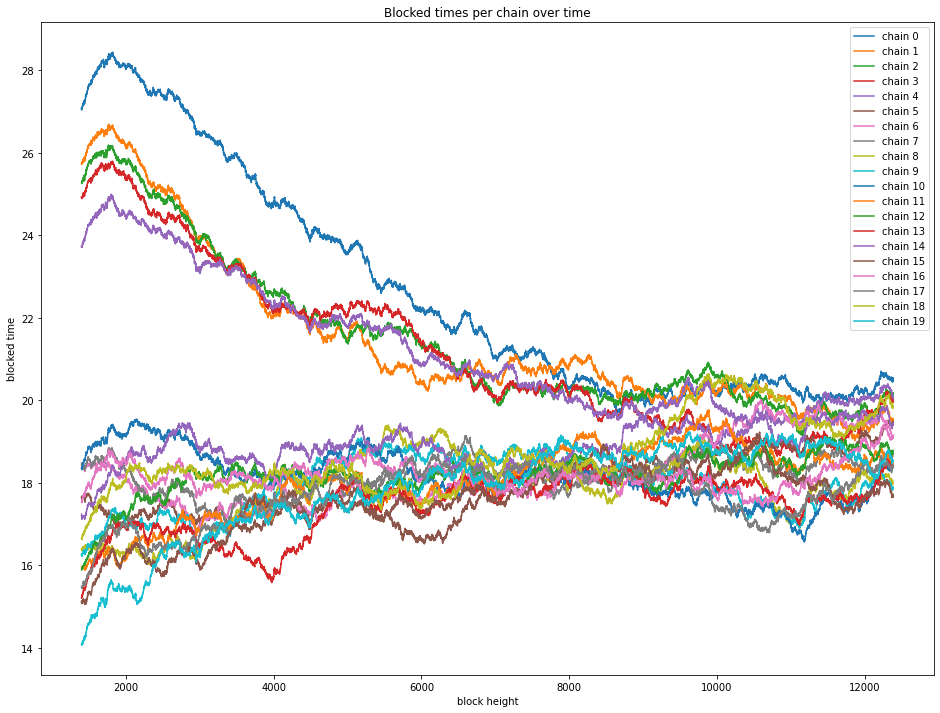

In [640]:
# plot the blocked times over time using a moving average to reduce noise from the individual curves.
#
for k,v in dat["blocked times"].items():
    df = pd.DataFrame(v)
    df["mavg"] = df.rolling(window=1200).mean()
    plt.plot(df["mavg"][1400:], label="chain %d" % k)
plt.title("Blocked times per chain over time")
plt.xlabel("block height")
plt.ylabel("blocked time")
plt.legend()
plt.show()

## Targets

After a short initial stabilization time, targets are expected to have a constant mean over time with a relatively small variance per chain. There should be no obvious oscillations.

If per chain target multipliers and `LocalDA` are used in mining targets are expected to start closely together and plateau after a few epoches on a chain specific value value.

Otherwise targets on all chains should have a similar mean with very little stanard deviation between chains (< 10%).

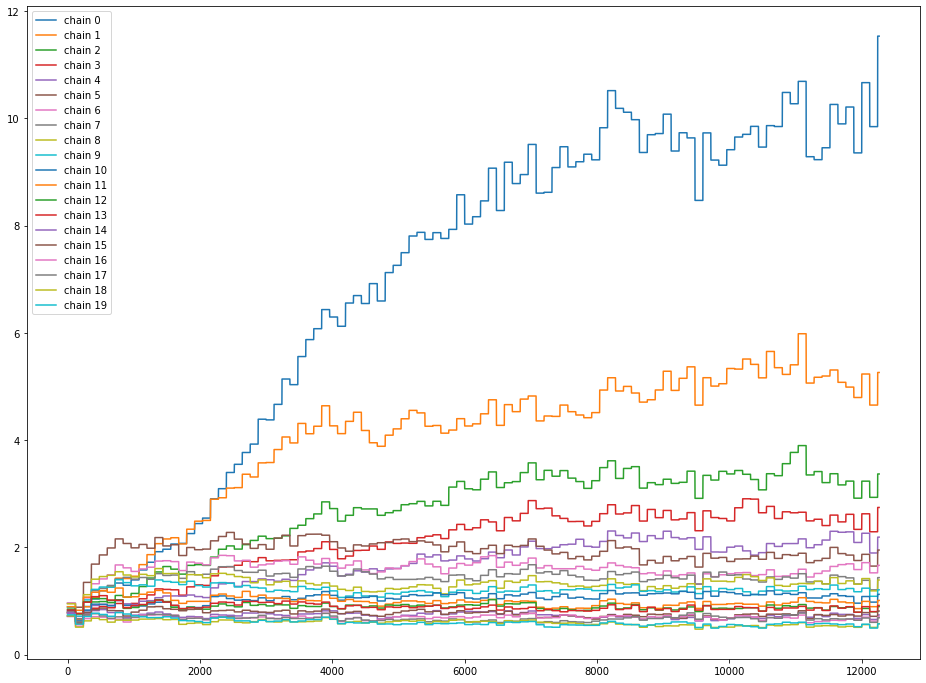

In [641]:
for c in chains:
    plt.plot(np.array(c.targets)[120:], label= "chain %d" % c.chain)
    plt.legend()

In [642]:
ts = [np.array(c.targets) for c in chains]
x = pd.DataFrame(ts)

In [643]:
d = x.describe()

In [644]:
d[[1000, 2000, 3000, 10000]]

,1000,2000,3000,10000
count,20.0000,20.0000,20.0000,20.0000
mean,1.0718,1.2271,1.4862,1.8497
std,0.3926,0.5496,0.9821,2.0456
min,0.6086,0.5841,0.6405,0.5170
25%,0.7486,0.8108,0.7911,0.6849
50%,0.9347,1.0530,1.1764,1.2032
75%,1.3626,1.5768,1.7078,1.8380
max,2.0733,2.3398,4.3911,9.1284
